In [1]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [2]:
# 試験ID生成
trial_prefix = 'nb027'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb027
nb027_20210606_181211


In [3]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [5]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [6]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [7]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [8]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [10]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 前処理_品詞変換

In [11]:
# テキスト情報を品詞に変換
def get_pos_tag(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return pos_tag

def get_pos_tag_to_text(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return " ".join(pos_tag)

## 実験で使うライブラリ群
- 本notebook通して、↓に従って進める。
  - https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/

In [13]:
import pandas as pd
import numpy as np
import torch
import transformers

from transformers import BertTokenizer
from tqdm import tqdm
tqdm.pandas()


In [69]:
128 + 32 +16

176

In [70]:
# 記事からclassをコピペ。コード理解のために、コメント入れたり改造したりする。
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # cudaが無いならcpuを使えばいいじゃない
        self.model_name = 'bert-base-uncased' # 学習済みモデルの名前を指定
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name) # 指定したmodel_nameでtokenizerを作成
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name) # 指定したmodel_nameで学習済みmodelを作成
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 176

    def get_imp(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        return [inp, len_inp]

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [71]:
BSV = BertSequenceVectorizer()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
text = train_base['excerpt'][0]

In [73]:
text

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [74]:
lst = BSV.get_imp(text)

In [75]:
len(text.split(" "))

174

In [76]:
lst[1]

220

In [77]:
# 特に頭使わず、雑に特徴化してみる

In [78]:
text_bert_out = train_base['excerpt'].progress_apply(lambda x: BSV.vectorize(x))

100%|██████████| 2834/2834 [22:47<00:00,  2.07it/s]


In [79]:
text_bert_test = test_base['excerpt'].progress_apply(lambda x: BSV.vectorize(x))

100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


In [80]:
df_bert_train = pd.DataFrame(np.stack(text_bert_out)).add_prefix('bert_pretrained_')
df_bert_test = pd.DataFrame(np.stack(text_bert_test)).add_prefix('bert_pretrained_')

In [81]:
df_bert_train.head()

,bert_pretrained_0,bert_pretrained_1,bert_pretrained_2,bert_pretrained_3,bert_pretrained_4,bert_pretrained_5,bert_pretrained_6,bert_pretrained_7,bert_pretrained_8,bert_pretrained_9,...,bert_pretrained_758,bert_pretrained_759,bert_pretrained_760,bert_pretrained_761,bert_pretrained_762,bert_pretrained_763,bert_pretrained_764,bert_pretrained_765,bert_pretrained_766,bert_pretrained_767
0,0.014009,-0.078737,0.029685,0.805308,-0.371418,-0.228234,-0.177632,0.509103,-0.243115,-0.517659,...,-0.207134,-0.359408,-0.484247,-0.051610,-0.016680,0.381065,-0.449925,-0.101726,0.535304,0.341834
1,-0.432926,0.039545,-0.410971,-0.385030,0.041933,-0.225337,-0.042956,0.302869,-0.624957,0.013671,...,-0.264664,-0.102047,0.027532,-0.424963,-0.079791,-0.257605,-0.216878,0.161870,0.353031,0.756497
2,-0.190136,0.160644,-0.177224,-0.184244,0.159106,-0.117992,-0.024649,0.282608,-0.346221,-0.291549,...,-0.173584,-0.102972,-0.325447,-0.286776,0.422103,-0.296627,-0.261972,-0.042259,0.534013,0.461021
3,0.206719,0.197944,0.269895,-0.414143,-0.031314,0.281739,0.180444,0.704109,-0.426331,-0.335456,...,-0.103776,-0.464270,-0.639133,0.039706,0.467368,0.189774,0.005939,0.157218,0.554878,0.125450
4,0.186515,0.423230,-0.017667,-0.337788,-0.265432,-0.056434,0.101273,1.682050,-0.238373,-0.196478,...,-0.606005,-0.516132,-0.651212,-0.489070,-0.005349,0.813413,0.491428,-0.306233,0.932022,0.311375


# make_feat

In [82]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [83]:
# fit & trainの特徴作成
train_feat = pd.concat([train_feat, df_bert_train], axis='columns')

In [84]:
# testの特徴作成
test_feat = pd.concat([test_feat, df_bert_test], axis='columns')

In [85]:
print(train_feat.shape)
train_feat.head()

(2834, 768)


,bert_pretrained_0,bert_pretrained_1,bert_pretrained_2,bert_pretrained_3,bert_pretrained_4,bert_pretrained_5,bert_pretrained_6,bert_pretrained_7,bert_pretrained_8,bert_pretrained_9,...,bert_pretrained_758,bert_pretrained_759,bert_pretrained_760,bert_pretrained_761,bert_pretrained_762,bert_pretrained_763,bert_pretrained_764,bert_pretrained_765,bert_pretrained_766,bert_pretrained_767
0,0.014009,-0.078737,0.029685,0.805308,-0.371418,-0.228234,-0.177632,0.509103,-0.243115,-0.517659,...,-0.207134,-0.359408,-0.484247,-0.051610,-0.016680,0.381065,-0.449925,-0.101726,0.535304,0.341834
1,-0.432926,0.039545,-0.410971,-0.385030,0.041933,-0.225337,-0.042956,0.302869,-0.624957,0.013671,...,-0.264664,-0.102047,0.027532,-0.424963,-0.079791,-0.257605,-0.216878,0.161870,0.353031,0.756497
2,-0.190136,0.160644,-0.177224,-0.184244,0.159106,-0.117992,-0.024649,0.282608,-0.346221,-0.291549,...,-0.173584,-0.102972,-0.325447,-0.286776,0.422103,-0.296627,-0.261972,-0.042259,0.534013,0.461021
3,0.206719,0.197944,0.269895,-0.414143,-0.031314,0.281739,0.180444,0.704109,-0.426331,-0.335456,...,-0.103776,-0.464270,-0.639133,0.039706,0.467368,0.189774,0.005939,0.157218,0.554878,0.125450
4,0.186515,0.423230,-0.017667,-0.337788,-0.265432,-0.056434,0.101273,1.682050,-0.238373,-0.196478,...,-0.606005,-0.516132,-0.651212,-0.489070,-0.005349,0.813413,0.491428,-0.306233,0.932022,0.311375


In [86]:
print(test_feat.shape)
test_feat.head()

(7, 768)


,bert_pretrained_0,bert_pretrained_1,bert_pretrained_2,bert_pretrained_3,bert_pretrained_4,bert_pretrained_5,bert_pretrained_6,bert_pretrained_7,bert_pretrained_8,bert_pretrained_9,...,bert_pretrained_758,bert_pretrained_759,bert_pretrained_760,bert_pretrained_761,bert_pretrained_762,bert_pretrained_763,bert_pretrained_764,bert_pretrained_765,bert_pretrained_766,bert_pretrained_767
0,0.146383,0.153908,-0.100685,-0.654840,0.171643,-0.559172,0.504636,0.599431,-0.325507,-0.485778,...,-0.033599,0.118298,0.213319,-0.041357,0.729218,-0.165288,-0.378525,0.267536,0.230020,0.854384
1,-0.313574,0.172065,-0.112328,-0.091196,-0.213311,-0.177378,0.282739,0.347908,-0.542623,0.047174,...,-0.125380,-0.086979,-0.379609,-0.192039,0.124346,0.098337,-0.374668,0.381955,0.468316,0.371970
2,-0.555157,0.498426,-0.407626,-0.166302,0.051213,-0.195008,-0.220178,0.207023,-0.579744,-0.178709,...,-0.413234,-0.290341,-0.408819,-0.511994,0.264188,-0.298070,-0.182996,0.071987,0.733685,0.350779
3,0.128457,0.102818,-0.139083,0.016574,-0.027535,-0.391036,0.319074,0.499890,-0.172829,-0.270648,...,0.444742,0.007536,-0.118277,0.064610,0.296243,-0.425644,-0.516306,-0.408527,0.240723,0.673341
4,0.128413,-0.203831,-0.640077,0.046038,-0.081988,-0.471696,-0.032558,0.222133,-0.143712,-0.294161,...,0.166165,-0.221264,0.027358,-0.075975,0.257648,-0.069494,-0.182535,0.049567,0.181635,1.012003


In [87]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 768)
(7, 768)


# train & predict

In [88]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [89]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [90]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [91]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [92]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 768
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.267934	valid's rmse: 0.685343
[100]	training's rmse: 0.112452	valid's rmse: 0.682727
Early stopping, best iteration is:
[101]	training's rmse: 0.11058	valid's rmse: 0.682619

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 768
[LightGBM] [Info] Start training from score -0.946950
Training until validation sco

In [93]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [94]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-0.713468
1,f0953f0a5,0.314732
2,0df072751,-0.666514
3,04caf4e0c,-1.510792
4,0e63f8bea,-1.332837


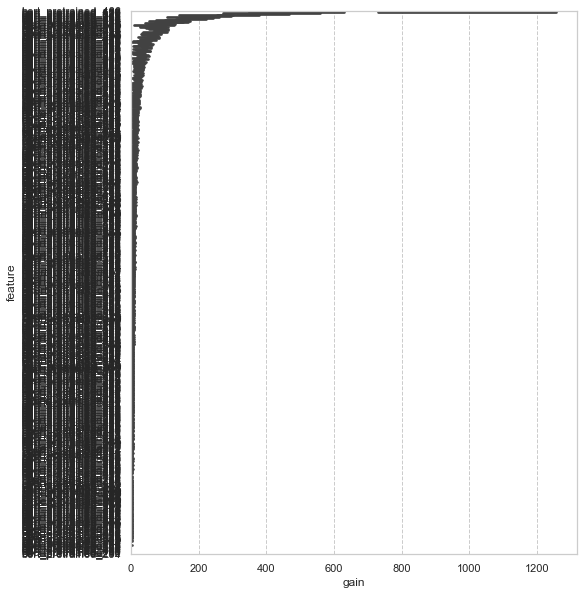

In [95]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

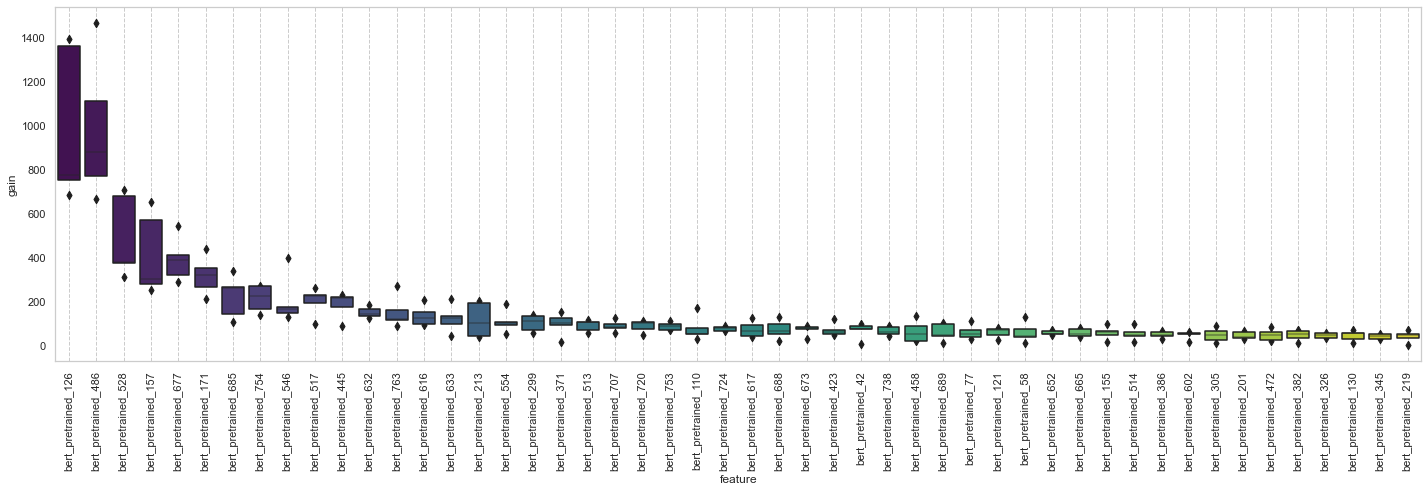

In [96]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [97]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

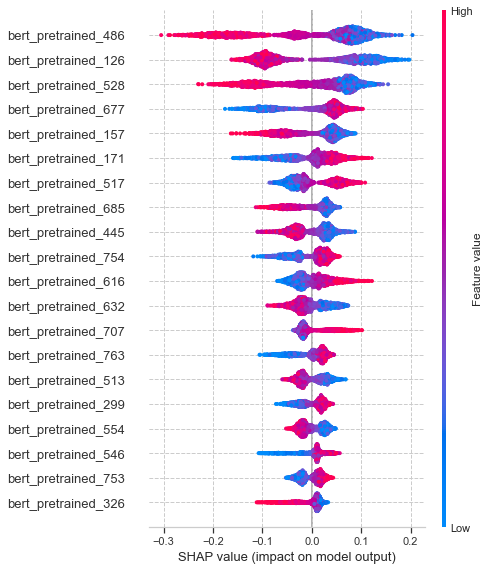

In [98]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

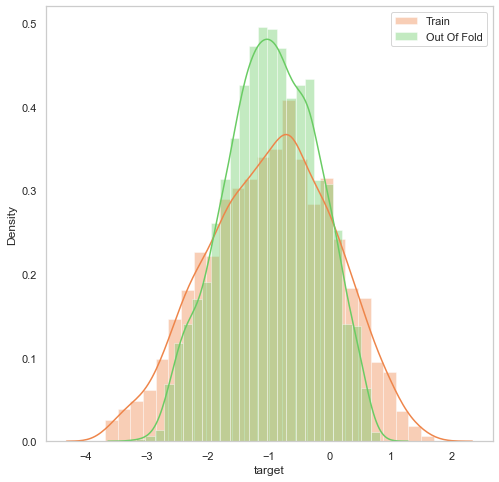

In [99]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))